<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:09:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


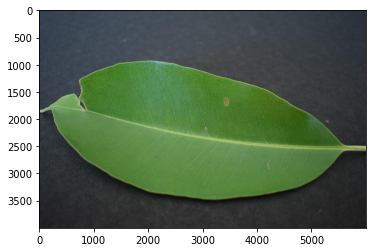

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

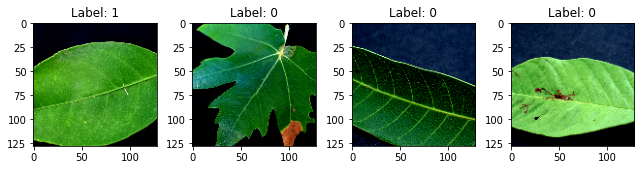

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:06] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:08] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2870981293627055 samples/sec                   batch loss = 0.6501597762107849 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.3007789997411967 samples/sec                   batch loss = 0.7747088670730591 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.3011938379256243 samples/sec                   batch loss = 0.4109286963939667 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.3023372215869882 samples/sec                   batch loss = 1.0366802215576172 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2964216842184 samples/sec                   batch loss = 0.8186644911766052 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.3031827169607781 samples/sec                   batch loss = 0.6468963027000427 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.299880922616126 samples/sec                   batch loss = 0.531620979309082 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2965011302991976 samples/sec                   batch loss = 0.8306839466094971 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.293679212707981 samples/sec                   batch loss = 0.604847252368927 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2964909109638196 samples/sec                   batch loss = 0.3824717700481415 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2995792553042749 samples/sec                   batch loss = 0.9741702675819397 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2972927163329733 samples/sec                   batch loss = 0.6279270648956299 | accuracy = 0.5708333333333333


Epoch[1] Batch[65] Speed: 1.2972830863820743 samples/sec                   batch loss = 0.29701313376426697 | accuracy = 0.573076923076923


Epoch[1] Batch[70] Speed: 1.2941956492845144 samples/sec                   batch loss = 0.32676807045936584 | accuracy = 0.5857142857142857


Epoch[1] Batch[75] Speed: 1.2977960802375283 samples/sec                   batch loss = 0.9497712850570679 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.2981624084955075 samples/sec                   batch loss = 0.3932721018791199 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.2995786513046161 samples/sec                   batch loss = 0.6815179586410522 | accuracy = 0.6058823529411764


Epoch[1] Batch[90] Speed: 1.2964005469894524 samples/sec                   batch loss = 0.5533991456031799 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.2972464738113767 samples/sec                   batch loss = 0.4355974793434143 | accuracy = 0.6210526315789474


Epoch[1] Batch[100] Speed: 1.297353909986589 samples/sec                   batch loss = 0.5028432011604309 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.2999817445457569 samples/sec                   batch loss = 0.529036819934845 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.303672225728441 samples/sec                   batch loss = 0.6653018593788147 | accuracy = 0.6204545454545455


Epoch[1] Batch[115] Speed: 1.2983965933335233 samples/sec                   batch loss = 0.4283650815486908 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.3021743789060556 samples/sec                   batch loss = 0.6216208934783936 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.300706591598739 samples/sec                   batch loss = 0.4223232567310333 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.3019357984821474 samples/sec                   batch loss = 0.36574381589889526 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.2960450239487529 samples/sec                   batch loss = 0.6465916633605957 | accuracy = 0.6407407407407407


Epoch[1] Batch[140] Speed: 1.295304260173609 samples/sec                   batch loss = 1.304161787033081 | accuracy = 0.6446428571428572


Epoch[1] Batch[145] Speed: 1.2999388353993497 samples/sec                   batch loss = 0.9084945917129517 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.3056263233041532 samples/sec                   batch loss = 0.402268648147583 | accuracy = 0.6483333333333333


Epoch[1] Batch[155] Speed: 1.3023211477790615 samples/sec                   batch loss = 0.35251298546791077 | accuracy = 0.6532258064516129


Epoch[1] Batch[160] Speed: 1.299114341729498 samples/sec                   batch loss = 1.0423555374145508 | accuracy = 0.653125


Epoch[1] Batch[165] Speed: 1.294447180877395 samples/sec                   batch loss = 0.6761062741279602 | accuracy = 0.65


Epoch[1] Batch[170] Speed: 1.3052796352701825 samples/sec                   batch loss = 0.5239126682281494 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.298869238833871 samples/sec                   batch loss = 0.5315438508987427 | accuracy = 0.6542857142857142


Epoch[1] Batch[180] Speed: 1.2943850627556892 samples/sec                   batch loss = 0.579955518245697 | accuracy = 0.6555555555555556


Epoch[1] Batch[185] Speed: 1.2988815068658595 samples/sec                   batch loss = 0.382291704416275 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.2924915274985453 samples/sec                   batch loss = 0.5774410963058472 | accuracy = 0.656578947368421


Epoch[1] Batch[195] Speed: 1.29535916549585 samples/sec                   batch loss = 0.514690637588501 | accuracy = 0.6602564102564102


Epoch[1] Batch[200] Speed: 1.2968699356767905 samples/sec                   batch loss = 0.4647444784641266 | accuracy = 0.66125


Epoch[1] Batch[205] Speed: 1.3014084227353286 samples/sec                   batch loss = 0.5688668489456177 | accuracy = 0.6646341463414634


Epoch[1] Batch[210] Speed: 1.293098502207804 samples/sec                   batch loss = 0.4202851951122284 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2995799599712528 samples/sec                   batch loss = 0.47370582818984985 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.3014193254519497 samples/sec                   batch loss = 0.5618168711662292 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.2969072287674857 samples/sec                   batch loss = 0.5904994606971741 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.302285463321851 samples/sec                   batch loss = 0.5025544762611389 | accuracy = 0.6565217391304348


Epoch[1] Batch[235] Speed: 1.2934117259596734 samples/sec                   batch loss = 0.3979516923427582 | accuracy = 0.6574468085106383


Epoch[1] Batch[240] Speed: 1.2919246163952725 samples/sec                   batch loss = 0.6208751201629639 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.301423666399228 samples/sec                   batch loss = 0.3654637038707733 | accuracy = 0.6571428571428571


Epoch[1] Batch[250] Speed: 1.2930689023360569 samples/sec                   batch loss = 0.5251835584640503 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.2986195040431852 samples/sec                   batch loss = 0.564814031124115 | accuracy = 0.6598039215686274


Epoch[1] Batch[260] Speed: 1.294584820719634 samples/sec                   batch loss = 0.6436768770217896 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.2946015032987337 samples/sec                   batch loss = 0.33611130714416504 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.2964544432763085 samples/sec                   batch loss = 0.9232467412948608 | accuracy = 0.6611111111111111


Epoch[1] Batch[275] Speed: 1.2921566553991113 samples/sec                   batch loss = 1.0085163116455078 | accuracy = 0.6581818181818182


Epoch[1] Batch[280] Speed: 1.2931448481632253 samples/sec                   batch loss = 0.42521411180496216 | accuracy = 0.6607142857142857


Epoch[1] Batch[285] Speed: 1.2965012304895576 samples/sec                   batch loss = 0.247747004032135 | accuracy = 0.6631578947368421


Epoch[1] Batch[290] Speed: 1.3016155046113773 samples/sec                   batch loss = 0.8443402647972107 | accuracy = 0.6603448275862069


Epoch[1] Batch[295] Speed: 1.3018514421716374 samples/sec                   batch loss = 0.6800152659416199 | accuracy = 0.661864406779661


Epoch[1] Batch[300] Speed: 1.2948552913456357 samples/sec                   batch loss = 1.7447654008865356 | accuracy = 0.6625


Epoch[1] Batch[305] Speed: 1.2997802170218427 samples/sec                   batch loss = 0.6267657279968262 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.300224949892733 samples/sec                   batch loss = 0.448691189289093 | accuracy = 0.6629032258064517


Epoch[1] Batch[315] Speed: 1.3006164456518015 samples/sec                   batch loss = 0.3250497877597809 | accuracy = 0.6642857142857143


Epoch[1] Batch[320] Speed: 1.2974106948354098 samples/sec                   batch loss = 0.3612152636051178 | accuracy = 0.66484375


Epoch[1] Batch[325] Speed: 1.302823060160499 samples/sec                   batch loss = 0.2692404091358185 | accuracy = 0.6676923076923077


Epoch[1] Batch[330] Speed: 1.2997108399461994 samples/sec                   batch loss = 0.7653197050094604 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2954599873876314 samples/sec                   batch loss = 0.33851495385169983 | accuracy = 0.6701492537313433


Epoch[1] Batch[340] Speed: 1.3008973106114619 samples/sec                   batch loss = 0.5838288068771362 | accuracy = 0.6691176470588235


Epoch[1] Batch[345] Speed: 1.297771384621549 samples/sec                   batch loss = 0.48218923807144165 | accuracy = 0.6695652173913044


Epoch[1] Batch[350] Speed: 1.3042491918027008 samples/sec                   batch loss = 0.31848862767219543 | accuracy = 0.6707142857142857


Epoch[1] Batch[355] Speed: 1.2946267777256995 samples/sec                   batch loss = 0.3781399726867676 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.291269645679309 samples/sec                   batch loss = 0.4512079060077667 | accuracy = 0.6715277777777777


Epoch[1] Batch[365] Speed: 1.2927994762599777 samples/sec                   batch loss = 1.1336811780929565 | accuracy = 0.6698630136986301


Epoch[1] Batch[370] Speed: 1.3003269338054764 samples/sec                   batch loss = 0.40341007709503174 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.298760043449881 samples/sec                   batch loss = 0.3497912883758545 | accuracy = 0.672


Epoch[1] Batch[380] Speed: 1.2961332355586952 samples/sec                   batch loss = 0.6467037796974182 | accuracy = 0.6723684210526316


Epoch[1] Batch[385] Speed: 1.2942433718613344 samples/sec                   batch loss = 0.45340073108673096 | accuracy = 0.6727272727272727


Epoch[1] Batch[390] Speed: 1.2995312390832494 samples/sec                   batch loss = 0.5104021430015564 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.299011843874677 samples/sec                   batch loss = 0.44622743129730225 | accuracy = 0.6765822784810127


Epoch[1] Batch[400] Speed: 1.2982743164066657 samples/sec                   batch loss = 0.241410031914711 | accuracy = 0.679375


Epoch[1] Batch[405] Speed: 1.2930958112543747 samples/sec                   batch loss = 0.4787689745426178 | accuracy = 0.6808641975308642


Epoch[1] Batch[410] Speed: 1.2972222003147562 samples/sec                   batch loss = 0.6156447529792786 | accuracy = 0.6823170731707318


Epoch[1] Batch[415] Speed: 1.2967329120132793 samples/sec                   batch loss = 0.27649086713790894 | accuracy = 0.6825301204819277


Epoch[1] Batch[420] Speed: 1.3018322488492042 samples/sec                   batch loss = 0.4999691843986511 | accuracy = 0.6833333333333333


Epoch[1] Batch[425] Speed: 1.3055426056091153 samples/sec                   batch loss = 0.5321637392044067 | accuracy = 0.6829411764705883


Epoch[1] Batch[430] Speed: 1.2991043829360729 samples/sec                   batch loss = 0.4594268202781677 | accuracy = 0.6843023255813954


Epoch[1] Batch[435] Speed: 1.297748797990832 samples/sec                   batch loss = 0.4122523069381714 | accuracy = 0.6856321839080459


Epoch[1] Batch[440] Speed: 1.2974683877138586 samples/sec                   batch loss = 0.5818031430244446 | accuracy = 0.6857954545454545


Epoch[1] Batch[445] Speed: 1.298583519587406 samples/sec                   batch loss = 0.6017481684684753 | accuracy = 0.6837078651685393


Epoch[1] Batch[450] Speed: 1.30177184408579 samples/sec                   batch loss = 0.42234688997268677 | accuracy = 0.6861111111111111


Epoch[1] Batch[455] Speed: 1.2978801126047548 samples/sec                   batch loss = 1.0003607273101807 | accuracy = 0.6884615384615385


Epoch[1] Batch[460] Speed: 1.2976404934729378 samples/sec                   batch loss = 0.5851489305496216 | accuracy = 0.6875


Epoch[1] Batch[465] Speed: 1.2936116823111963 samples/sec                   batch loss = 0.4653577506542206 | accuracy = 0.6876344086021505


Epoch[1] Batch[470] Speed: 1.2983887556663023 samples/sec                   batch loss = 0.31374675035476685 | accuracy = 0.6877659574468085


Epoch[1] Batch[475] Speed: 1.3010353167177977 samples/sec                   batch loss = 0.8462570905685425 | accuracy = 0.6884210526315789


Epoch[1] Batch[480] Speed: 1.3004573594691642 samples/sec                   batch loss = 0.2680240273475647 | accuracy = 0.690625


Epoch[1] Batch[485] Speed: 1.2959225889136512 samples/sec                   batch loss = 0.8085423111915588 | accuracy = 0.6912371134020618


Epoch[1] Batch[490] Speed: 1.2995332522707264 samples/sec                   batch loss = 0.6863213181495667 | accuracy = 0.689795918367347


Epoch[1] Batch[495] Speed: 1.3010424801147094 samples/sec                   batch loss = 0.3519199788570404 | accuracy = 0.6914141414141414


Epoch[1] Batch[500] Speed: 1.2951323736081095 samples/sec                   batch loss = 0.4579311013221741 | accuracy = 0.6905


Epoch[1] Batch[505] Speed: 1.2983768988624083 samples/sec                   batch loss = 0.6051371097564697 | accuracy = 0.692079207920792


Epoch[1] Batch[510] Speed: 1.3011381341561077 samples/sec                   batch loss = 0.30550283193588257 | accuracy = 0.6916666666666667


Epoch[1] Batch[515] Speed: 1.2975888067719699 samples/sec                   batch loss = 0.581344485282898 | accuracy = 0.6932038834951456


Epoch[1] Batch[520] Speed: 1.3053074610311182 samples/sec                   batch loss = 0.36576515436172485 | accuracy = 0.6942307692307692


Epoch[1] Batch[525] Speed: 1.3015463353684167 samples/sec                   batch loss = 0.2256547063589096 | accuracy = 0.6947619047619048


Epoch[1] Batch[530] Speed: 1.2961171142656567 samples/sec                   batch loss = 0.8579586744308472 | accuracy = 0.6952830188679245


Epoch[1] Batch[535] Speed: 1.29312431599676 samples/sec                   batch loss = 0.2424880713224411 | accuracy = 0.6967289719626168


Epoch[1] Batch[540] Speed: 1.287969329881494 samples/sec                   batch loss = 0.6307258009910583 | accuracy = 0.6953703703703704


Epoch[1] Batch[545] Speed: 1.2881336828609176 samples/sec                   batch loss = 0.41136911511421204 | accuracy = 0.6954128440366972


Epoch[1] Batch[550] Speed: 1.288523669799036 samples/sec                   batch loss = 0.4128442108631134 | accuracy = 0.695


Epoch[1] Batch[555] Speed: 1.2999949401813988 samples/sec                   batch loss = 0.4445452392101288 | accuracy = 0.6963963963963964


Epoch[1] Batch[560] Speed: 1.2928422142494853 samples/sec                   batch loss = 0.7443364858627319 | accuracy = 0.6964285714285714


Epoch[1] Batch[565] Speed: 1.2986349840035494 samples/sec                   batch loss = 0.4647354781627655 | accuracy = 0.6946902654867256


Epoch[1] Batch[570] Speed: 1.2920253023305674 samples/sec                   batch loss = 1.3274227380752563 | accuracy = 0.6947368421052632


Epoch[1] Batch[575] Speed: 1.2937330824812274 samples/sec                   batch loss = 0.6596876978874207 | accuracy = 0.6947826086956522


Epoch[1] Batch[580] Speed: 1.301034913148488 samples/sec                   batch loss = 0.4766579866409302 | accuracy = 0.6961206896551724


Epoch[1] Batch[585] Speed: 1.3007181884609942 samples/sec                   batch loss = 0.6598184704780579 | accuracy = 0.697008547008547


Epoch[1] Batch[590] Speed: 1.2931304955122545 samples/sec                   batch loss = 0.5837563872337341 | accuracy = 0.6974576271186441


Epoch[1] Batch[595] Speed: 1.2891955706094242 samples/sec                   batch loss = 1.2805737257003784 | accuracy = 0.6974789915966386


Epoch[1] Batch[600] Speed: 1.291178318765404 samples/sec                   batch loss = 0.8061164617538452 | accuracy = 0.6979166666666666


Epoch[1] Batch[605] Speed: 1.2944588661420846 samples/sec                   batch loss = 0.5296329259872437 | accuracy = 0.6975206611570248


Epoch[1] Batch[610] Speed: 1.2991599127017903 samples/sec                   batch loss = 0.3114235997200012 | accuracy = 0.6967213114754098


Epoch[1] Batch[615] Speed: 1.297742473875118 samples/sec                   batch loss = 0.18708011507987976 | accuracy = 0.6979674796747968


Epoch[1] Batch[620] Speed: 1.3052158639138793 samples/sec                   batch loss = 0.1803540289402008 | accuracy = 0.6975806451612904


Epoch[1] Batch[625] Speed: 1.29820741043494 samples/sec                   batch loss = 0.3987758755683899 | accuracy = 0.6992


Epoch[1] Batch[630] Speed: 1.2958103854578844 samples/sec                   batch loss = 0.22527198493480682 | accuracy = 0.7


Epoch[1] Batch[635] Speed: 1.295929495916411 samples/sec                   batch loss = 0.5262843370437622 | accuracy = 0.7


Epoch[1] Batch[640] Speed: 1.3019784354109984 samples/sec                   batch loss = 0.5125744342803955 | accuracy = 0.698828125


Epoch[1] Batch[645] Speed: 1.299381877972597 samples/sec                   batch loss = 0.6942898035049438 | accuracy = 0.6984496124031008


Epoch[1] Batch[650] Speed: 1.2995633501672013 samples/sec                   batch loss = 0.3804098665714264 | accuracy = 0.6988461538461539


Epoch[1] Batch[655] Speed: 1.2994563529407208 samples/sec                   batch loss = 0.41624778509140015 | accuracy = 0.6984732824427481


Epoch[1] Batch[660] Speed: 1.3025253854092482 samples/sec                   batch loss = 0.2906493842601776 | accuracy = 0.6992424242424242


Epoch[1] Batch[665] Speed: 1.2990707857089652 samples/sec                   batch loss = 0.3945297300815582 | accuracy = 0.7003759398496241


Epoch[1] Batch[670] Speed: 1.2990179792087018 samples/sec                   batch loss = 0.5866793990135193 | accuracy = 0.7003731343283582


Epoch[1] Batch[675] Speed: 1.2941321577557414 samples/sec                   batch loss = 0.8611805438995361 | accuracy = 0.7011111111111111


Epoch[1] Batch[680] Speed: 1.294096022277572 samples/sec                   batch loss = 0.5274525880813599 | accuracy = 0.7022058823529411


Epoch[1] Batch[685] Speed: 1.2920089845719465 samples/sec                   batch loss = 1.2219555377960205 | accuracy = 0.7014598540145985


Epoch[1] Batch[690] Speed: 1.2897553294068962 samples/sec                   batch loss = 0.3737718164920807 | accuracy = 0.7021739130434783


Epoch[1] Batch[695] Speed: 1.2921219238467323 samples/sec                   batch loss = 0.6896058917045593 | accuracy = 0.702158273381295


Epoch[1] Batch[700] Speed: 1.2934751468160584 samples/sec                   batch loss = 0.5116280913352966 | accuracy = 0.7014285714285714


Epoch[1] Batch[705] Speed: 1.294706903183069 samples/sec                   batch loss = 0.3861131966114044 | accuracy = 0.701418439716312


Epoch[1] Batch[710] Speed: 1.294685422193433 samples/sec                   batch loss = 0.640522301197052 | accuracy = 0.7003521126760563


Epoch[1] Batch[715] Speed: 1.2897804149630745 samples/sec                   batch loss = 0.6600273847579956 | accuracy = 0.701048951048951


Epoch[1] Batch[720] Speed: 1.2903752184695487 samples/sec                   batch loss = 0.27433332800865173 | accuracy = 0.7017361111111111


Epoch[1] Batch[725] Speed: 1.2961269271788762 samples/sec                   batch loss = 0.25033432245254517 | accuracy = 0.7020689655172414


Epoch[1] Batch[730] Speed: 1.300876430658759 samples/sec                   batch loss = 0.4492069482803345 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2977445819068407 samples/sec                   batch loss = 0.5643497109413147 | accuracy = 0.7010204081632653


Epoch[1] Batch[740] Speed: 1.300819039459427 samples/sec                   batch loss = 0.6625427007675171 | accuracy = 0.7016891891891892


Epoch[1] Batch[745] Speed: 1.300339229389381 samples/sec                   batch loss = 0.9524374008178711 | accuracy = 0.7016778523489933


Epoch[1] Batch[750] Speed: 1.2949611323697676 samples/sec                   batch loss = 1.806235432624817 | accuracy = 0.702


Epoch[1] Batch[755] Speed: 1.2937753833734769 samples/sec                   batch loss = 1.0420608520507812 | accuracy = 0.7016556291390729


Epoch[1] Batch[760] Speed: 1.2889037928715172 samples/sec                   batch loss = 0.6550886631011963 | accuracy = 0.7003289473684211


Epoch[1] Batch[765] Speed: 1.2908357840585796 samples/sec                   batch loss = 0.34720781445503235 | accuracy = 0.7009803921568627


Epoch[1] Batch[770] Speed: 1.2967072546192622 samples/sec                   batch loss = 0.6303708553314209 | accuracy = 0.700974025974026


Epoch[1] Batch[775] Speed: 1.3014618276006114 samples/sec                   batch loss = 0.3735703229904175 | accuracy = 0.7016129032258065


Epoch[1] Batch[780] Speed: 1.2992266150544949 samples/sec                   batch loss = 0.30439895391464233 | accuracy = 0.7022435897435897


Epoch[1] Batch[785] Speed: 1.2974054776454664 samples/sec                   batch loss = 0.23976953327655792 | accuracy = 0.7038216560509554


[Epoch 1] training: accuracy=0.7030456852791879
[Epoch 1] time cost: 634.9406161308289
[Epoch 1] validation: validation accuracy=0.7511111111111111


Epoch[2] Batch[5] Speed: 1.3011284470308642 samples/sec                   batch loss = 0.5780366659164429 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2940998154097636 samples/sec                   batch loss = 0.6935150027275085 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2917942056726721 samples/sec                   batch loss = 0.4059407711029053 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2961453518255004 samples/sec                   batch loss = 0.4239645302295685 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.3003181657852152 samples/sec                   batch loss = 0.3725428283214569 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.299321599756635 samples/sec                   batch loss = 0.34444552659988403 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.29416040872017 samples/sec                   batch loss = 0.4667007625102997 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.298196360562607 samples/sec                   batch loss = 0.8027207255363464 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.2959716402385169 samples/sec                   batch loss = 0.4420671761035919 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2957279218010425 samples/sec                   batch loss = 0.9514502882957458 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.296288761544428 samples/sec                   batch loss = 0.44256392121315 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2993973761138875 samples/sec                   batch loss = 0.6324712038040161 | accuracy = 0.75


Epoch[2] Batch[65] Speed: 1.2973095690910714 samples/sec                   batch loss = 0.34512242674827576 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.2936583643147042 samples/sec                   batch loss = 0.42487362027168274 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2984119674940708 samples/sec                   batch loss = 0.2487589716911316 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.299159309091861 samples/sec                   batch loss = 0.4574475586414337 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.299639456753518 samples/sec                   batch loss = 0.41082578897476196 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.3011092750207296 samples/sec                   batch loss = 0.710882842540741 | accuracy = 0.75


Epoch[2] Batch[95] Speed: 1.2952838593820208 samples/sec                   batch loss = 0.8651226758956909 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.296592710749633 samples/sec                   batch loss = 0.39881542325019836 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.296965779236647 samples/sec                   batch loss = 0.37592363357543945 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2974647754874267 samples/sec                   batch loss = 0.35432010889053345 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2959784476545617 samples/sec                   batch loss = 0.23618696630001068 | accuracy = 0.7565217391304347


Epoch[2] Batch[120] Speed: 1.3002216245996874 samples/sec                   batch loss = 0.20310218632221222 | accuracy = 0.7625


Epoch[2] Batch[125] Speed: 1.2965808867256388 samples/sec                   batch loss = 0.29351338744163513 | accuracy = 0.766


Epoch[2] Batch[130] Speed: 1.2984790955451448 samples/sec                   batch loss = 0.35363245010375977 | accuracy = 0.7615384615384615


Epoch[2] Batch[135] Speed: 1.2981577879372772 samples/sec                   batch loss = 0.5420945882797241 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2975051131576631 samples/sec                   batch loss = 0.7962580919265747 | accuracy = 0.7625


Epoch[2] Batch[145] Speed: 1.2967265977947815 samples/sec                   batch loss = 0.32495787739753723 | accuracy = 0.7620689655172413


Epoch[2] Batch[150] Speed: 1.2986992197300038 samples/sec                   batch loss = 0.5354294180870056 | accuracy = 0.7633333333333333


Epoch[2] Batch[155] Speed: 1.2941853664286298 samples/sec                   batch loss = 0.2170492261648178 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2949176545010912 samples/sec                   batch loss = 0.384520024061203 | accuracy = 0.7625


Epoch[2] Batch[165] Speed: 1.2979223838946128 samples/sec                   batch loss = 0.37944281101226807 | accuracy = 0.7636363636363637


Epoch[2] Batch[170] Speed: 1.2949776247388871 samples/sec                   batch loss = 0.3403368294239044 | accuracy = 0.7647058823529411


Epoch[2] Batch[175] Speed: 1.3025807023643357 samples/sec                   batch loss = 0.4537575840950012 | accuracy = 0.7657142857142857


Epoch[2] Batch[180] Speed: 1.2943984446124648 samples/sec                   batch loss = 0.1607881635427475 | accuracy = 0.7722222222222223


Epoch[2] Batch[185] Speed: 1.3001700343532785 samples/sec                   batch loss = 0.7053213715553284 | accuracy = 0.7716216216216216


Epoch[2] Batch[190] Speed: 1.2977054338636658 samples/sec                   batch loss = 0.7548266649246216 | accuracy = 0.7723684210526316


Epoch[2] Batch[195] Speed: 1.2972288202692004 samples/sec                   batch loss = 0.3688398003578186 | accuracy = 0.7730769230769231


Epoch[2] Batch[200] Speed: 1.2936097871728178 samples/sec                   batch loss = 0.42656204104423523 | accuracy = 0.77375


Epoch[2] Batch[205] Speed: 1.296724392844078 samples/sec                   batch loss = 0.6451842188835144 | accuracy = 0.7719512195121951


Epoch[2] Batch[210] Speed: 1.2934780387958233 samples/sec                   batch loss = 0.14949539303779602 | accuracy = 0.7726190476190476


Epoch[2] Batch[215] Speed: 1.2981145973532793 samples/sec                   batch loss = 0.2971825897693634 | accuracy = 0.7744186046511627


Epoch[2] Batch[220] Speed: 1.298520199828827 samples/sec                   batch loss = 0.44014444947242737 | accuracy = 0.7761363636363636


Epoch[2] Batch[225] Speed: 1.2989421465259416 samples/sec                   batch loss = 0.26675546169281006 | accuracy = 0.7788888888888889


Epoch[2] Batch[230] Speed: 1.2958473173672045 samples/sec                   batch loss = 0.3688446879386902 | accuracy = 0.7793478260869565


Epoch[2] Batch[235] Speed: 1.3033579621856264 samples/sec                   batch loss = 0.8114848136901855 | accuracy = 0.7819148936170213


Epoch[2] Batch[240] Speed: 1.2970836982791925 samples/sec                   batch loss = 0.400078684091568 | accuracy = 0.7833333333333333


Epoch[2] Batch[245] Speed: 1.3010387470670395 samples/sec                   batch loss = 0.41963276267051697 | accuracy = 0.7826530612244897


Epoch[2] Batch[250] Speed: 1.2976451103494624 samples/sec                   batch loss = 0.44447842240333557 | accuracy = 0.783


Epoch[2] Batch[255] Speed: 1.2944639597850247 samples/sec                   batch loss = 0.5854712724685669 | accuracy = 0.7813725490196078


Epoch[2] Batch[260] Speed: 1.2942397775698182 samples/sec                   batch loss = 0.561429500579834 | accuracy = 0.7798076923076923


Epoch[2] Batch[265] Speed: 1.2887137033047011 samples/sec                   batch loss = 0.2671942114830017 | accuracy = 0.7830188679245284


Epoch[2] Batch[270] Speed: 1.294595209820185 samples/sec                   batch loss = 0.5315737724304199 | accuracy = 0.7824074074074074


Epoch[2] Batch[275] Speed: 1.291058291720319 samples/sec                   batch loss = 0.164022296667099 | accuracy = 0.7854545454545454


Epoch[2] Batch[280] Speed: 1.2939301444051257 samples/sec                   batch loss = 0.344213604927063 | accuracy = 0.7866071428571428


Epoch[2] Batch[285] Speed: 1.289317728616752 samples/sec                   batch loss = 0.6480647921562195 | accuracy = 0.7868421052631579


Epoch[2] Batch[290] Speed: 1.2897104158092154 samples/sec                   batch loss = 0.33100083470344543 | accuracy = 0.7879310344827586


Epoch[2] Batch[295] Speed: 1.2914324562656723 samples/sec                   batch loss = 0.48427528142929077 | accuracy = 0.788135593220339


Epoch[2] Batch[300] Speed: 1.2888274532922253 samples/sec                   batch loss = 0.12232063710689545 | accuracy = 0.7883333333333333


Epoch[2] Batch[305] Speed: 1.2931273060775277 samples/sec                   batch loss = 0.4478914737701416 | accuracy = 0.7860655737704918


Epoch[2] Batch[310] Speed: 1.2923970409519043 samples/sec                   batch loss = 0.42963120341300964 | accuracy = 0.7870967741935484


Epoch[2] Batch[315] Speed: 1.2887645863696597 samples/sec                   batch loss = 0.2745293974876404 | accuracy = 0.7849206349206349


Epoch[2] Batch[320] Speed: 1.296097288629046 samples/sec                   batch loss = 0.6599702835083008 | accuracy = 0.7859375


Epoch[2] Batch[325] Speed: 1.2989716136121368 samples/sec                   batch loss = 0.531915009021759 | accuracy = 0.7838461538461539


Epoch[2] Batch[330] Speed: 1.2946345700405493 samples/sec                   batch loss = 0.3911178708076477 | accuracy = 0.7863636363636364


Epoch[2] Batch[335] Speed: 1.2954745918597184 samples/sec                   batch loss = 0.31641408801078796 | accuracy = 0.7880597014925373


Epoch[2] Batch[340] Speed: 1.2984459326165 samples/sec                   batch loss = 0.9142120480537415 | accuracy = 0.788235294117647


Epoch[2] Batch[345] Speed: 1.301071840776976 samples/sec                   batch loss = 2.1225812435150146 | accuracy = 0.7869565217391304


Epoch[2] Batch[350] Speed: 1.300539317261695 samples/sec                   batch loss = 0.08554494380950928 | accuracy = 0.785


Epoch[2] Batch[355] Speed: 1.2984874367907828 samples/sec                   batch loss = 0.3453752100467682 | accuracy = 0.7852112676056338


Epoch[2] Batch[360] Speed: 1.3014696014530471 samples/sec                   batch loss = 0.7938932776451111 | accuracy = 0.7840277777777778


Epoch[2] Batch[365] Speed: 1.2965085444276623 samples/sec                   batch loss = 0.0515245646238327 | accuracy = 0.7835616438356164


Epoch[2] Batch[370] Speed: 1.2948252112659533 samples/sec                   batch loss = 0.2629423141479492 | accuracy = 0.7844594594594595


Epoch[2] Batch[375] Speed: 1.298781257690537 samples/sec                   batch loss = 0.4784804582595825 | accuracy = 0.7833333333333333


Epoch[2] Batch[380] Speed: 1.2993290461783669 samples/sec                   batch loss = 0.2561914026737213 | accuracy = 0.7842105263157895


Epoch[2] Batch[385] Speed: 1.2964229865346681 samples/sec                   batch loss = 0.44813594222068787 | accuracy = 0.7844155844155845


Epoch[2] Batch[390] Speed: 1.3036513579028213 samples/sec                   batch loss = 0.45997676253318787 | accuracy = 0.7833333333333333


Epoch[2] Batch[395] Speed: 1.3030114656076817 samples/sec                   batch loss = 0.4052751660346985 | accuracy = 0.7822784810126582


Epoch[2] Batch[400] Speed: 1.295328361936814 samples/sec                   batch loss = 0.1326712667942047 | accuracy = 0.780625


Epoch[2] Batch[405] Speed: 1.2970894142878238 samples/sec                   batch loss = 0.5480189323425293 | accuracy = 0.7802469135802469


Epoch[2] Batch[410] Speed: 1.3007171800299804 samples/sec                   batch loss = 0.44893720746040344 | accuracy = 0.7804878048780488


Epoch[2] Batch[415] Speed: 1.2939129801701539 samples/sec                   batch loss = 0.7406795620918274 | accuracy = 0.7801204819277109


Epoch[2] Batch[420] Speed: 1.2935235143849728 samples/sec                   batch loss = 0.4261293113231659 | accuracy = 0.7803571428571429


Epoch[2] Batch[425] Speed: 1.2981820964601025 samples/sec                   batch loss = 0.4736667573451996 | accuracy = 0.7811764705882352


Epoch[2] Batch[430] Speed: 1.2968116945756758 samples/sec                   batch loss = 0.6965835094451904 | accuracy = 0.7802325581395348


Epoch[2] Batch[435] Speed: 1.2923584139714956 samples/sec                   batch loss = 0.6038174629211426 | accuracy = 0.7793103448275862


Epoch[2] Batch[440] Speed: 1.2890326302304187 samples/sec                   batch loss = 1.165895938873291 | accuracy = 0.7795454545454545


Epoch[2] Batch[445] Speed: 1.2939572887759732 samples/sec                   batch loss = 0.3919086456298828 | accuracy = 0.7792134831460674


Epoch[2] Batch[450] Speed: 1.2977332387692446 samples/sec                   batch loss = 0.43167373538017273 | accuracy = 0.7794444444444445


Epoch[2] Batch[455] Speed: 1.2916762519097347 samples/sec                   batch loss = 0.6396900415420532 | accuracy = 0.778021978021978


Epoch[2] Batch[460] Speed: 1.298580001661034 samples/sec                   batch loss = 0.25353676080703735 | accuracy = 0.778804347826087


Epoch[2] Batch[465] Speed: 1.3011041289457703 samples/sec                   batch loss = 0.6940581798553467 | accuracy = 0.7795698924731183


Epoch[2] Batch[470] Speed: 1.2954907972072984 samples/sec                   batch loss = 0.2465209662914276 | accuracy = 0.7808510638297872


Epoch[2] Batch[475] Speed: 1.2938954172383026 samples/sec                   batch loss = 0.2718193829059601 | accuracy = 0.781578947368421


Epoch[2] Batch[480] Speed: 1.2989776479926614 samples/sec                   batch loss = 0.44965314865112305 | accuracy = 0.7817708333333333


Epoch[2] Batch[485] Speed: 1.2934517122845954 samples/sec                   batch loss = 0.1291276216506958 | accuracy = 0.7835051546391752


Epoch[2] Batch[490] Speed: 1.2970935258339558 samples/sec                   batch loss = 0.08783207088708878 | accuracy = 0.7846938775510204


Epoch[2] Batch[495] Speed: 1.2965688625156235 samples/sec                   batch loss = 0.4740326702594757 | accuracy = 0.7828282828282829


Epoch[2] Batch[500] Speed: 1.2941942516051868 samples/sec                   batch loss = 0.865949273109436 | accuracy = 0.782


Epoch[2] Batch[505] Speed: 1.2940199646885264 samples/sec                   batch loss = 0.48717349767684937 | accuracy = 0.7811881188118812


Epoch[2] Batch[510] Speed: 1.3010633653982089 samples/sec                   batch loss = 1.4877169132232666 | accuracy = 0.7803921568627451


Epoch[2] Batch[515] Speed: 1.3036247169410056 samples/sec                   batch loss = 0.3780500292778015 | accuracy = 0.7800970873786408


Epoch[2] Batch[520] Speed: 1.2993370964600355 samples/sec                   batch loss = 0.2499914914369583 | accuracy = 0.7807692307692308


Epoch[2] Batch[525] Speed: 1.2987286757952976 samples/sec                   batch loss = 0.3089565932750702 | accuracy = 0.7804761904761904


Epoch[2] Batch[530] Speed: 1.2963041859879334 samples/sec                   batch loss = 0.5567576885223389 | accuracy = 0.7806603773584906


Epoch[2] Batch[535] Speed: 1.2913174508796539 samples/sec                   batch loss = 0.354057639837265 | accuracy = 0.7799065420560748


Epoch[2] Batch[540] Speed: 1.2918236477451626 samples/sec                   batch loss = 0.5818648338317871 | accuracy = 0.7800925925925926


Epoch[2] Batch[545] Speed: 1.2984019189819087 samples/sec                   batch loss = 0.7275218367576599 | accuracy = 0.7798165137614679


Epoch[2] Batch[550] Speed: 1.295731124077266 samples/sec                   batch loss = 1.3393114805221558 | accuracy = 0.7795454545454545


Epoch[2] Batch[555] Speed: 1.2979586329655122 samples/sec                   batch loss = 0.4240366518497467 | accuracy = 0.7783783783783784


Epoch[2] Batch[560] Speed: 1.2998174762730388 samples/sec                   batch loss = 0.10111716389656067 | accuracy = 0.7790178571428571


Epoch[2] Batch[565] Speed: 1.2976684963373841 samples/sec                   batch loss = 0.4293300211429596 | accuracy = 0.7787610619469026


Epoch[2] Batch[570] Speed: 1.288408885045718 samples/sec                   batch loss = 0.47436678409576416 | accuracy = 0.7785087719298246


Epoch[2] Batch[575] Speed: 1.2960886776828795 samples/sec                   batch loss = 0.7856828570365906 | accuracy = 0.778695652173913


Epoch[2] Batch[580] Speed: 1.29388593744481 samples/sec                   batch loss = 0.6228814125061035 | accuracy = 0.7788793103448276


Epoch[2] Batch[585] Speed: 1.2957446338543277 samples/sec                   batch loss = 0.27705684304237366 | accuracy = 0.7782051282051282


Epoch[2] Batch[590] Speed: 1.2936645489354297 samples/sec                   batch loss = 0.41124334931373596 | accuracy = 0.7792372881355932


Epoch[2] Batch[595] Speed: 1.2929675554634863 samples/sec                   batch loss = 0.27203279733657837 | accuracy = 0.7794117647058824


Epoch[2] Batch[600] Speed: 1.2959940649380686 samples/sec                   batch loss = 0.29815661907196045 | accuracy = 0.77875


Epoch[2] Batch[605] Speed: 1.293966370419 samples/sec                   batch loss = 0.38628968596458435 | accuracy = 0.7785123966942149


Epoch[2] Batch[610] Speed: 1.3004521177478074 samples/sec                   batch loss = 0.6436360478401184 | accuracy = 0.7786885245901639


Epoch[2] Batch[615] Speed: 1.2928962136052513 samples/sec                   batch loss = 0.48669326305389404 | accuracy = 0.7784552845528455


Epoch[2] Batch[620] Speed: 1.299907007909364 samples/sec                   batch loss = 0.9874042868614197 | accuracy = 0.7786290322580646


Epoch[2] Batch[625] Speed: 1.2991881823950924 samples/sec                   batch loss = 0.3837493360042572 | accuracy = 0.7784


Epoch[2] Batch[630] Speed: 1.2927435923831667 samples/sec                   batch loss = 0.3013695180416107 | accuracy = 0.778968253968254


Epoch[2] Batch[635] Speed: 1.3020821093567252 samples/sec                   batch loss = 0.27972328662872314 | accuracy = 0.7791338582677165


Epoch[2] Batch[640] Speed: 1.2965231725514346 samples/sec                   batch loss = 0.33397889137268066 | accuracy = 0.778515625


Epoch[2] Batch[645] Speed: 1.2974780204160106 samples/sec                   batch loss = 0.4800794720649719 | accuracy = 0.7786821705426357


Epoch[2] Batch[650] Speed: 1.3024297295146712 samples/sec                   batch loss = 1.2304837703704834 | accuracy = 0.7788461538461539


Epoch[2] Batch[655] Speed: 1.296646623015958 samples/sec                   batch loss = 0.35738405585289 | accuracy = 0.7782442748091603


Epoch[2] Batch[660] Speed: 1.2978327238386453 samples/sec                   batch loss = 0.21670915186405182 | accuracy = 0.7791666666666667


Epoch[2] Batch[665] Speed: 1.2974883556617505 samples/sec                   batch loss = 0.17485648393630981 | accuracy = 0.7796992481203008


Epoch[2] Batch[670] Speed: 1.3015637027206886 samples/sec                   batch loss = 0.6141930222511292 | accuracy = 0.7794776119402985


Epoch[2] Batch[675] Speed: 1.3021750863901365 samples/sec                   batch loss = 0.7024703025817871 | accuracy = 0.7792592592592592


Epoch[2] Batch[680] Speed: 1.2958938605762216 samples/sec                   batch loss = 0.41059085726737976 | accuracy = 0.7794117647058824


Epoch[2] Batch[685] Speed: 1.2961620746484561 samples/sec                   batch loss = 0.5970113277435303 | accuracy = 0.7781021897810219


Epoch[2] Batch[690] Speed: 1.2991955266804414 samples/sec                   batch loss = 0.798285186290741 | accuracy = 0.7786231884057971


Epoch[2] Batch[695] Speed: 1.292632237495483 samples/sec                   batch loss = 0.6317824721336365 | accuracy = 0.7780575539568345


Epoch[2] Batch[700] Speed: 1.3005846857950492 samples/sec                   batch loss = 0.7403333187103271 | accuracy = 0.7785714285714286


Epoch[2] Batch[705] Speed: 1.2986600140708933 samples/sec                   batch loss = 0.25992998480796814 | accuracy = 0.7790780141843971


Epoch[2] Batch[710] Speed: 1.2917094677381677 samples/sec                   batch loss = 0.5486871004104614 | accuracy = 0.7792253521126761


Epoch[2] Batch[715] Speed: 1.3006073712487376 samples/sec                   batch loss = 0.365606427192688 | accuracy = 0.779020979020979


Epoch[2] Batch[720] Speed: 1.2981414153544082 samples/sec                   batch loss = 0.2505455017089844 | accuracy = 0.7788194444444444


Epoch[2] Batch[725] Speed: 1.3011872783571918 samples/sec                   batch loss = 0.4017332196235657 | accuracy = 0.7782758620689655


Epoch[2] Batch[730] Speed: 1.3011915168400028 samples/sec                   batch loss = 0.47501808404922485 | accuracy = 0.7787671232876713


Epoch[2] Batch[735] Speed: 1.3044759424594883 samples/sec                   batch loss = 0.2346973568201065 | accuracy = 0.7792517006802722


Epoch[2] Batch[740] Speed: 1.3001778935405386 samples/sec                   batch loss = 0.36037302017211914 | accuracy = 0.7787162162162162


Epoch[2] Batch[745] Speed: 1.297456648051493 samples/sec                   batch loss = 0.25859084725379944 | accuracy = 0.7788590604026846


Epoch[2] Batch[750] Speed: 1.296711263520149 samples/sec                   batch loss = 0.24442313611507416 | accuracy = 0.778


Epoch[2] Batch[755] Speed: 1.2958250979174535 samples/sec                   batch loss = 0.2486070692539215 | accuracy = 0.7781456953642384


Epoch[2] Batch[760] Speed: 1.300961467703235 samples/sec                   batch loss = 0.1848410815000534 | accuracy = 0.7786184210526316


Epoch[2] Batch[765] Speed: 1.2983319856454016 samples/sec                   batch loss = 0.07544083893299103 | accuracy = 0.7790849673202614


Epoch[2] Batch[770] Speed: 1.299311335909825 samples/sec                   batch loss = 0.4873582124710083 | accuracy = 0.7795454545454545


Epoch[2] Batch[775] Speed: 1.295102780525246 samples/sec                   batch loss = 0.40431636571884155 | accuracy = 0.7793548387096774


Epoch[2] Batch[780] Speed: 1.2926560407295826 samples/sec                   batch loss = 0.17940741777420044 | accuracy = 0.7798076923076923


Epoch[2] Batch[785] Speed: 1.2868043392290718 samples/sec                   batch loss = 0.2435501515865326 | accuracy = 0.7796178343949045


[Epoch 2] training: accuracy=0.7801395939086294
[Epoch 2] time cost: 625.9075164794922
[Epoch 2] validation: validation accuracy=0.7788888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7533333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)